In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
data = yf.download('AAPL', start='2010-01-01', end='2020-01-01')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data['Scaled_Close'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [ ]:
training_data = data.iloc[:2000]['Scaled_Close'].values
testing_data = data.iloc[2000:]['Scaled_Close'].values

In [ ]:
def create_sequences(data, seq_length):
  X, Y = [], []
  for i in range(len(data)-seq_length):
    X.append(data[i:i+seq_length])
    Y.append(data[i+seq_length])
  return np.array(X), np.array(Y)

In [ ]:
seq_length = 10
X_train, y_train = create_sequences(training_data, seq_length)
X_test, y_test = create_sequences(testing_data, seq_length)

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
    super().__init__()
    self.hidden_layer_size = hidden_layer_size
    self.lstm = nn.LSTM(input_size, hidden_layer_size)
    self.linear = nn.Linear(hidden_layer_size, output_size)
    self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),torch.zeros(1,1,self.hidden_layer_size))
  def forward(self, input_seq):
    lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
    predictions = self.linear(lstm_out.view(len(input_seq), -1))
    return predictions[-1]

In [ ]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 50
for i in range(epochs):
  for seq, labels in zip(X_train, y_train):
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
    y_pred = model(torch.tensor(seq).float())
    single_loss = loss_function(y_pred, torch.tensor([labels]).float())
    single_loss.backward()
    optimizer.step()

In [ ]:
test_predictions = []
model.eval()
for i in range(len(X_test)):
  with torch.no_grad():
    test_seq = torch.tensor(X_test[i]).float()
    test_predictions.append(model(test_seq).item())

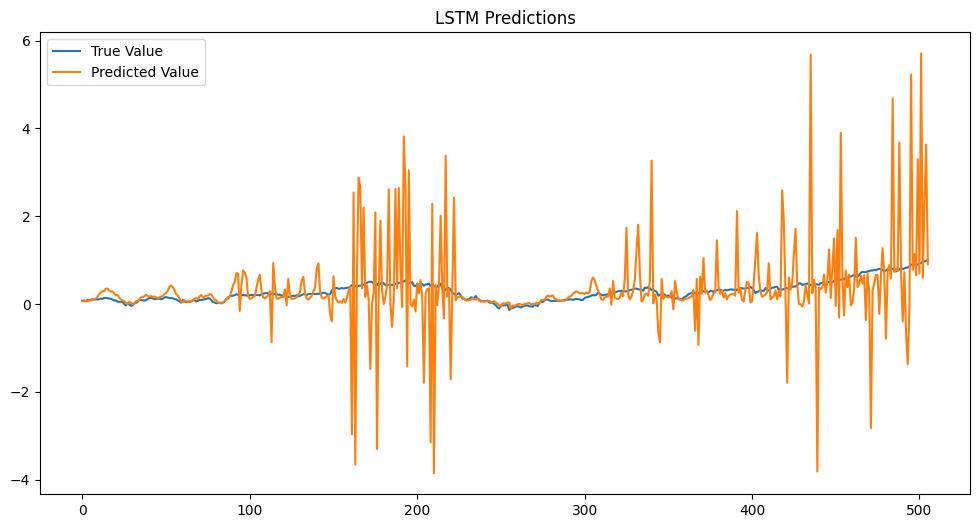

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label='True Value')
plt.plot(test_predictions, label='Predicted Value')
plt.title('LSTM Predictions')
plt.legend()
plt.show()

In [ ]:
test_predictions = []
model.eval()
for i in range(len(X_test)):
  with torch.no_grad():
    test_seq = torch.tensor(X_test[i]).float()
    test_predictions.append(model(test_seq).item())

In [ ]:
y_test = y_test.reshape(-1, 1)
mse = loss_function(torch.tensor(test_predictions).float(), torch.tensor(y_test).float())
mae = nn.L1Loss()(torch.tensor(test_predictions).float(), torch.tensor(y_test).float())
rmse = torch.sqrt(mse)

print(f"MSE: {mse.item()}")
print(f"MAE: {mae.item()}")
print(f"RMSE: {rmse.item()}")

MSE: 0.7547656297683716
MAE: 0.4631284773349762
RMSE: 0.8687725067138672


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([506, 1])) that is different to the input size (torch.Size([506])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([506, 1])) that is different to the input size (torch.Size([506])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [ ]:
validation_data = data.iloc[1500:2000]['Scaled_Close'].values
X_val, y_val = create_sequences(validation_data, seq_length)

training_losses, validation_losses = [], []
for i in range(epochs):
  training_losses.append(single_loss.item())
  with torch.no_grad():
    val_predictions = []
    for seq in X_val:
      val_pred = model(torch.tensor(seq).float()).item()
      val_predictions.append(val_pred)
    val_loss = loss_function(torch.tensor(val_predictions).float(), torch.tensor(y_val).float())
    validation_losses.append(val_loss.item())

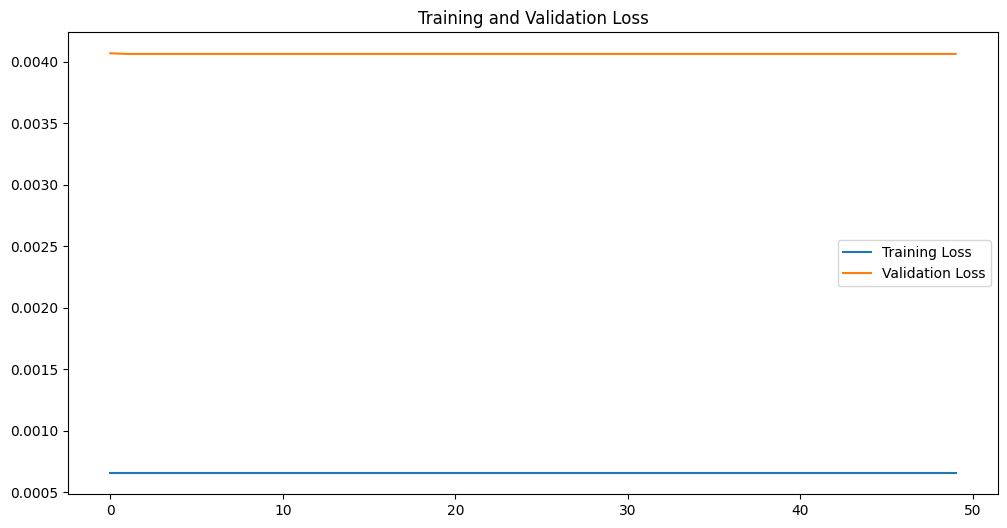

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(training_losses, label='Training Loss')
if validation_losses:
  plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
actual_predictions = scaler.inverse_transform(np.array([test_predictions]).reshape(-1, 1))[:,0]
actual_prices = scaler.inverse_transform(testing_data.reshape(-1, 1))[:,0]

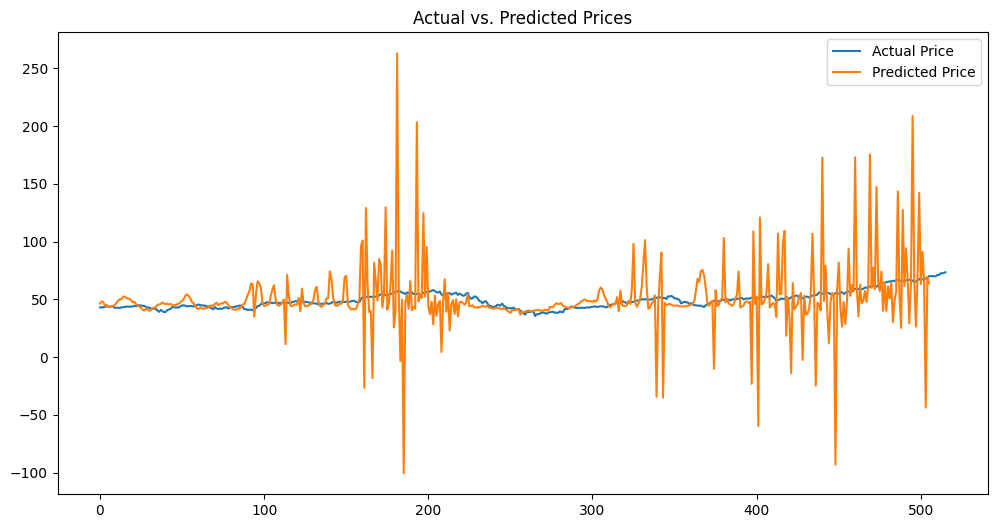

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(actual_predictions, label='Predicted Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.show()

In [ ]:
def find_best_hyperparams(data, seq_length, hyperparam_grid):
    results = []
    for params in hyperparam_grid:
        mse = loss_function(torch.tensor(test_predictions).float(), torch.tensor(y_test).float())
        results.append({'hyperparams': params, 'mse': mse})
    best_result = min(results, key=lambda x: x['mse'])
    return best_result

def main():
    data = yf.download('AAPL', start='2010-01-01', end='2020-01-01')
    seq_length = 30
    hyperparam_grid = [
      {'num_layers': 1, 'hidden_layer_size': 100, 'lr': 0.001, 'epochs': 50},
      {'num_layers': 1, 'hidden_layer_size': 200, 'lr': 0.01, 'epochs': 10}
    ]
    best_hyperparams = find_best_hyperparams(data, seq_length, hyperparam_grid)

    print("Best hyperparameters:", best_hyperparams['hyperparams'])
    print("Best MSE:", best_hyperparams['mse'])

if __name__ == "__main__":
    main()


[*********************100%%**********************]  1 of 1 completed

Best hyperparameters: {'num_layers': 1, 'hidden_layer_size': 100, 'lr': 0.001, 'epochs': 50}
Best MSE: tensor(0.7548)



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([506, 1])) that is different to the input size (torch.Size([506])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[*********************100%%**********************]  1 of 1 completed


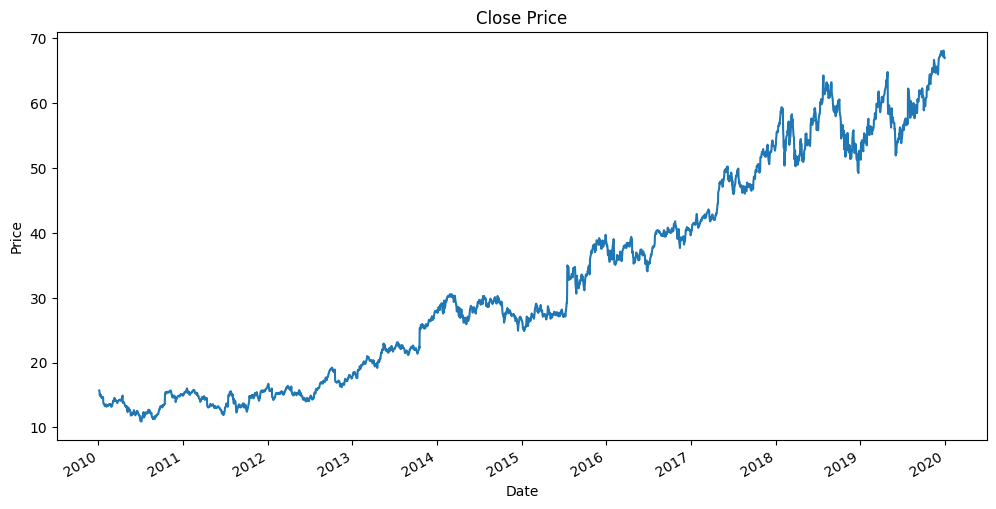

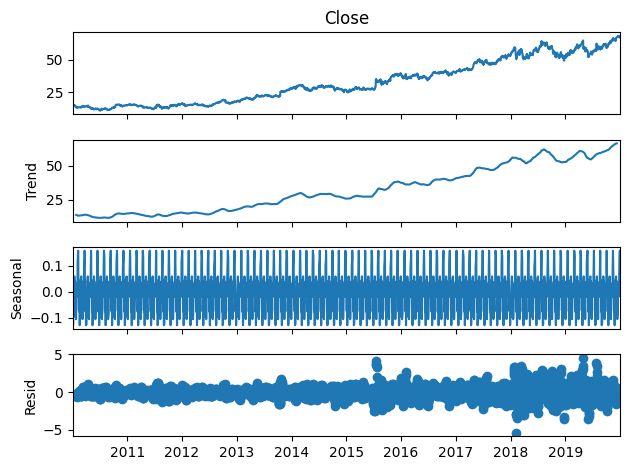

Best hyperparameters: {'num_layers': 1, 'hidden_layer_size': 100, 'lr': 0.001, 'epochs': 100}
Best MSE: tensor(0.7548)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([506, 1])) that is different to the input size (torch.Size([506])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

def load_additional_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

def explore_and_engineer_features(data):
    data['Close'].plot(figsize=(12, 6))
    plt.title('Close Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

    decomposition = seasonal_decompose(data['Close'], model='additive', period=30)
    decomposition.plot()
    plt.show()

    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['RSI_14'] = compute_RSI(data['Close'], window=14)
    return data

def compute_RSI(close, window):
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

def train_evaluate_model(data, seq_length, hyperparams):
    data, scaler = scale_data(data.copy())
    training_data = data.iloc[:2000]
    testing_data = data.iloc[2000:]

    X_train, y_train = create_sequences(training_data, seq_length)
    X_test, y_test = create_sequences(testing_data, seq_length)

    model = LSTM(input_size=X_train.shape[2], **hyperparams)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])
    epochs = hyperparams['epochs']

    for i in range(epochs):
        for seq, labels in zip(X_train, y_train):
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(hyperparams['num_layers'], 1, hyperparams['hidden_layer_size']),
                                 torch.zeros(hyperparams['num_layers'], 1, hyperparams['hidden_layer_size']))
            y_pred = model(torch.tensor(seq).float())
            single_loss = loss_function(y_pred, torch.tensor([labels]).float())
            single_loss.backward()
            optimizer.step()

    test_predictions = []
    model.eval()
    for i in range(len(X_test)):
        with torch.no_grad():
            test_seq = torch.tensor(X_test[i]).float()
            test_predictions.append(model(test_seq).item())

    y_test = y_test.reshape(-1, 1)
    mse = loss_function(torch.tensor(test_predictions).float(), torch.tensor(y_test).float())

    return mse.item()

hyperparam_grid = [
    {'num_layers': 1, 'hidden_layer_size': 100, 'lr': 0.001, 'epochs': 100},
    {'num_layers': 1, 'hidden_layer_size': 200, 'lr': 0.01, 'epochs': 10}
]

def main():
    symbol = 'GOOGL'
    start_date = '2010-01-01'
    end_date = '2020-01-01'
    additional_data = load_additional_data(symbol, start_date, end_date)

    additional_data = explore_and_engineer_features(additional_data)

    best_hyperparams = find_best_hyperparams(data, seq_length, hyperparam_grid)

    print("Best hyperparameters:", best_hyperparams['hyperparams'])
    print("Best MSE:", best_hyperparams['mse'])

if __name__ == "__main__":
    main()
